In [1]:
import pandas as pd
import numpy as np
from pytrends.request import TrendReq

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

### Bitcoin

In [2]:
data = pd.read_csv('../../data/processed/SOL-USD_raw.csv', index_col='Date', parse_dates=True)

In [3]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Close,2026.0,8.442304e+01,7.463384e+01,0.515273,2.034899e+01,4.512917e+01,1.487481e+02,2.618698e+02
High,2026.0,8.753539e+01,7.713699e+01,0.559759,2.092448e+01,4.837252e+01,1.538436e+02,2.943350e+02
Low,2026.0,8.118624e+01,7.202592e+01,0.505194,1.979724e+01,4.274958e+01,1.447272e+02,2.531874e+02
Open,2026.0,8.434070e+01,7.463489e+01,0.513391,2.032012e+01,4.494825e+01,1.487131e+02,2.618724e+02
Volume,2026.0,2.182471e+09,2.677272e+09,652020.000000,3.238079e+08,1.367602e+09,3.022110e+09,3.317296e+10


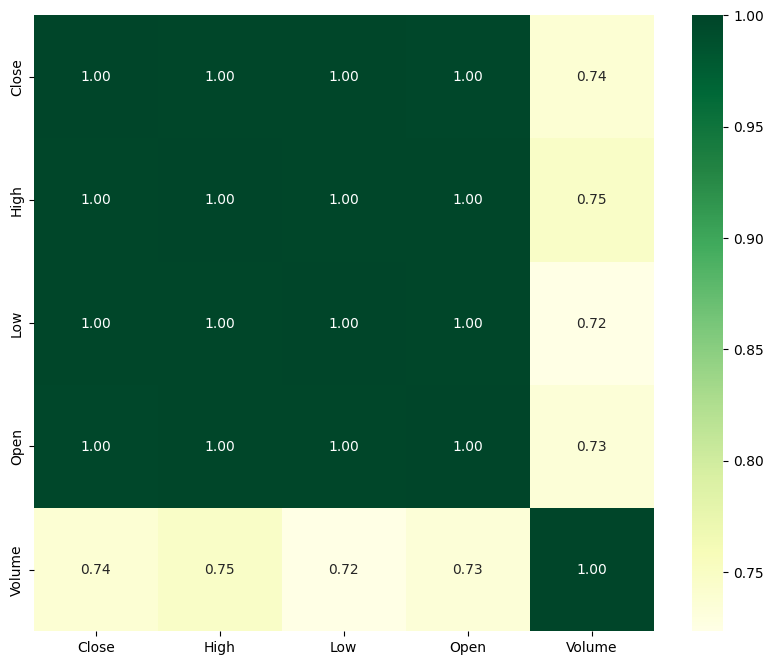

In [4]:
plt.figure(figsize=(10, 8)) 
sns.heatmap(data.corr(), annot=True, cmap="YlGn", fmt=".2f")
plt.show()

In [5]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data)
data_scaled = pd.DataFrame(scaled_data, columns=data.columns, index=data.index)

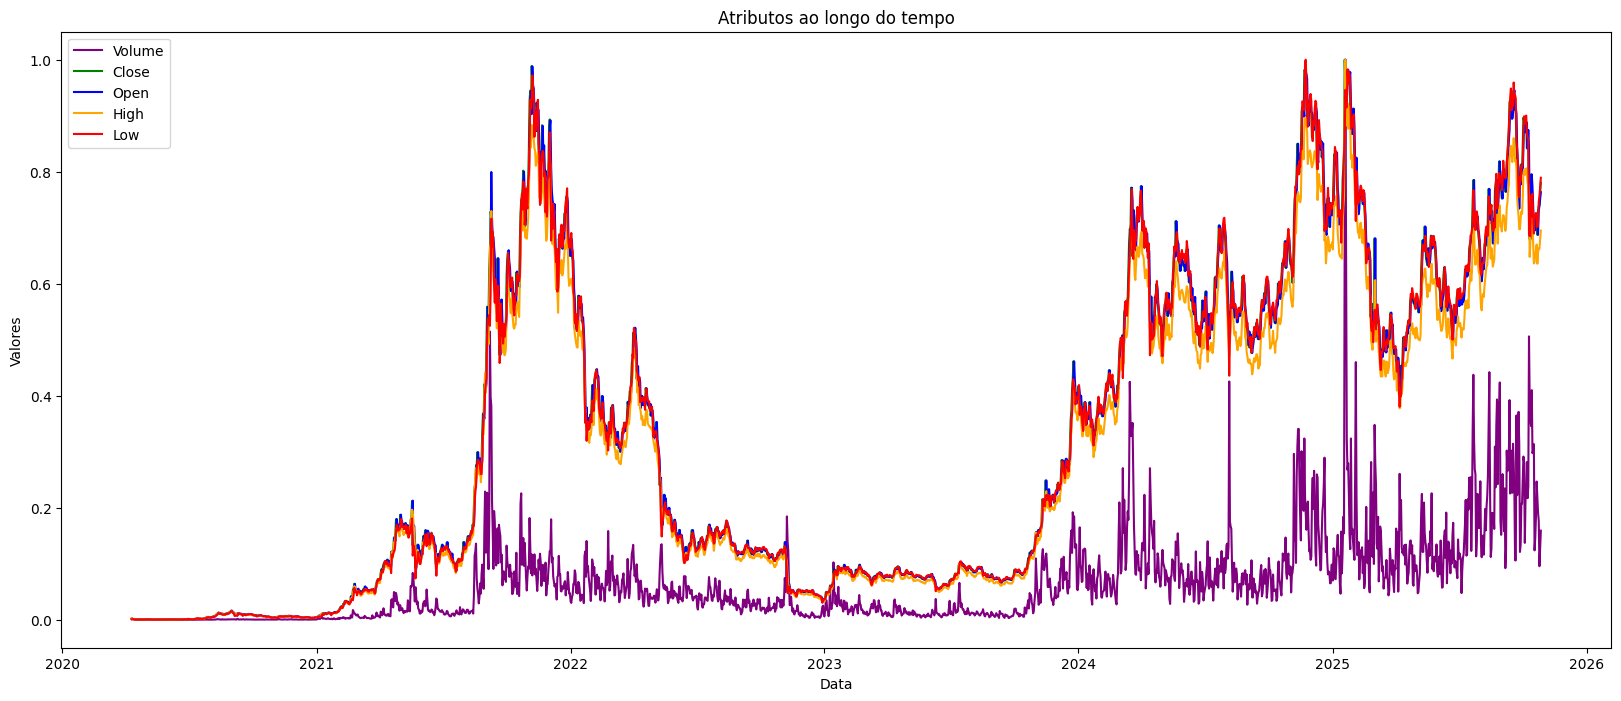

In [6]:
plt.figure(figsize=(20,8))

plt.plot(data_scaled.index, data_scaled['Volume'], label='Volume', color='purple')
plt.plot(data_scaled.index, data_scaled['Close'], label='Close', color='green')
plt.plot(data_scaled.index, data_scaled['Open'], label='Open', color='blue')
plt.plot(data_scaled.index, data_scaled['High'], label='High', color='orange')
plt.plot(data_scaled.index, data_scaled['Low'], label='Low', color='red')

plt.title('Atributos ao longo do tempo')
plt.xlabel('Data')
plt.ylabel('Valores')
plt.legend()
plt.show()

#### Adicionando Google Trends

In [7]:
from pytrends.request import TrendReq
import pandas as pd
import time

# Configuração PyTrends
pytrends = TrendReq(hl='en-US', tz=360)

# Termos que você quer pesquisar
kw_list = ["crypto", "solana", "bitcoin"]

# Função para gerar intervalos anuais entre datas inicial e final
def generate_halfyear_intervals(start_year, start_month, start_day, end_year, end_month, end_day):
    intervals = []
    current_start = pd.Timestamp(year=start_year, month=start_month, day=start_day)
    final_end = pd.Timestamp(year=end_year, month=end_month, day=end_day)

    while current_start < final_end:
        current_end = current_start + pd.DateOffset(months=6) - pd.DateOffset(days=1)
        if current_end > final_end:
            current_end = final_end
        intervals.append((current_start.strftime('%Y-%m-%d'), current_end.strftime('%Y-%m-%d')))
        current_start = current_end + pd.DateOffset(days=1)
    return intervals

intervals = generate_halfyear_intervals(2020, 4, 10, 2025, 10, 27)

dfs = []

# Loop para buscar os dados de cada intervalo
for start, end in intervals:
    print(f"Buscando dados de {start} até {end}...")
    pytrends.build_payload(kw_list, cat=0, timeframe=f'{start} {end}', geo='')
    
    # Tentar pegar os dados e lidar com possíveis falhas
    try:
        df = pytrends.interest_over_time()
        if not df.empty:
            dfs.append(df)
    except Exception as e:
        print(f"Erro ao buscar dados: {e}")
    
    # Espera para não ser bloqueado
    time.sleep(60)  

# Concatenar todos os intervalos em um único DataFrame
interest_over_time_df = pd.concat(dfs)
interest_over_time_df = interest_over_time_df[~interest_over_time_df.index.duplicated(keep='first')]


Buscando dados de 2020-04-10 até 2020-10-09...
Buscando dados de 2020-10-10 até 2021-04-09...
Buscando dados de 2021-04-10 até 2021-10-09...
Buscando dados de 2021-10-10 até 2022-04-09...
Buscando dados de 2022-04-10 até 2022-10-09...
Buscando dados de 2022-10-10 até 2023-04-09...
Buscando dados de 2023-04-10 até 2023-10-09...
Buscando dados de 2023-10-10 até 2024-04-09...
Buscando dados de 2024-04-10 até 2024-10-09...
Buscando dados de 2024-10-10 até 2025-04-09...
Buscando dados de 2025-04-10 até 2025-10-09...
Buscando dados de 2025-10-10 até 2025-10-27...


In [8]:
# Mostrar os primeiros dados
interest_over_time_df.head(10)

,crypto,solana,bitcoin,isPartial
date,,,,
2020-04-10,6,2,46,False
2020-04-11,6,1,41,False
2020-04-12,5,1,42,False
2020-04-13,5,2,44,False
2020-04-14,5,1,41,False
2020-04-15,5,1,41,False
2020-04-16,5,1,43,False
2020-04-17,5,1,39,False
2020-04-18,5,1,39,False


In [9]:
# Seleciona apenas as colunas de interesse do Google Trends
trends_cols = interest_over_time_df[["crypto", "solana", "bitcoin"]]

# Faz o merge pelo índice de datas
data_merged = data.merge(trends_cols, left_index=True, right_index=True, how='left')


In [10]:
data_merged.head(10)

,Close,High,Low,Open,Volume,crypto,solana,bitcoin
Date,,,,,,,,
2020-04-10,0.951054,1.313487,0.694187,0.832005,87364276,6,2,46
2020-04-11,0.776819,1.049073,0.765020,0.951054,43862444,6,1,41
2020-04-12,0.882507,0.956670,0.762426,0.785448,38736897,5,1,42
2020-04-13,0.777832,0.891603,0.773976,0.890760,18211285,5,2,44
2020-04-14,0.661925,0.796472,0.628169,0.777832,16747614,5,1,41
2020-04-15,0.646651,0.704964,0.621531,0.669289,13075275,5,1,41
2020-04-16,0.690816,0.774192,0.625107,0.630879,21346031,5,1,43
2020-04-17,0.660728,0.719614,0.660728,0.689312,9870810,5,1,39
2020-04-18,0.681096,0.717618,0.659427,0.660728,9782112,5,1,39


In [11]:
data_merged.isna().sum()

Close      0
High       0
Low        0
Open       0
Volume     0
crypto     0
solana     0
bitcoin    0
dtype: int64

In [17]:
data_merged = data_merged.drop(columns="bitcoin")

In [19]:
data_merged.to_csv('../../data/processed/SOL-USD_crypto_all.csv', index=True)

In [20]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data_merged)
data_scaled = pd.DataFrame(scaled_data, columns=data_merged.columns, index=data_merged.index)

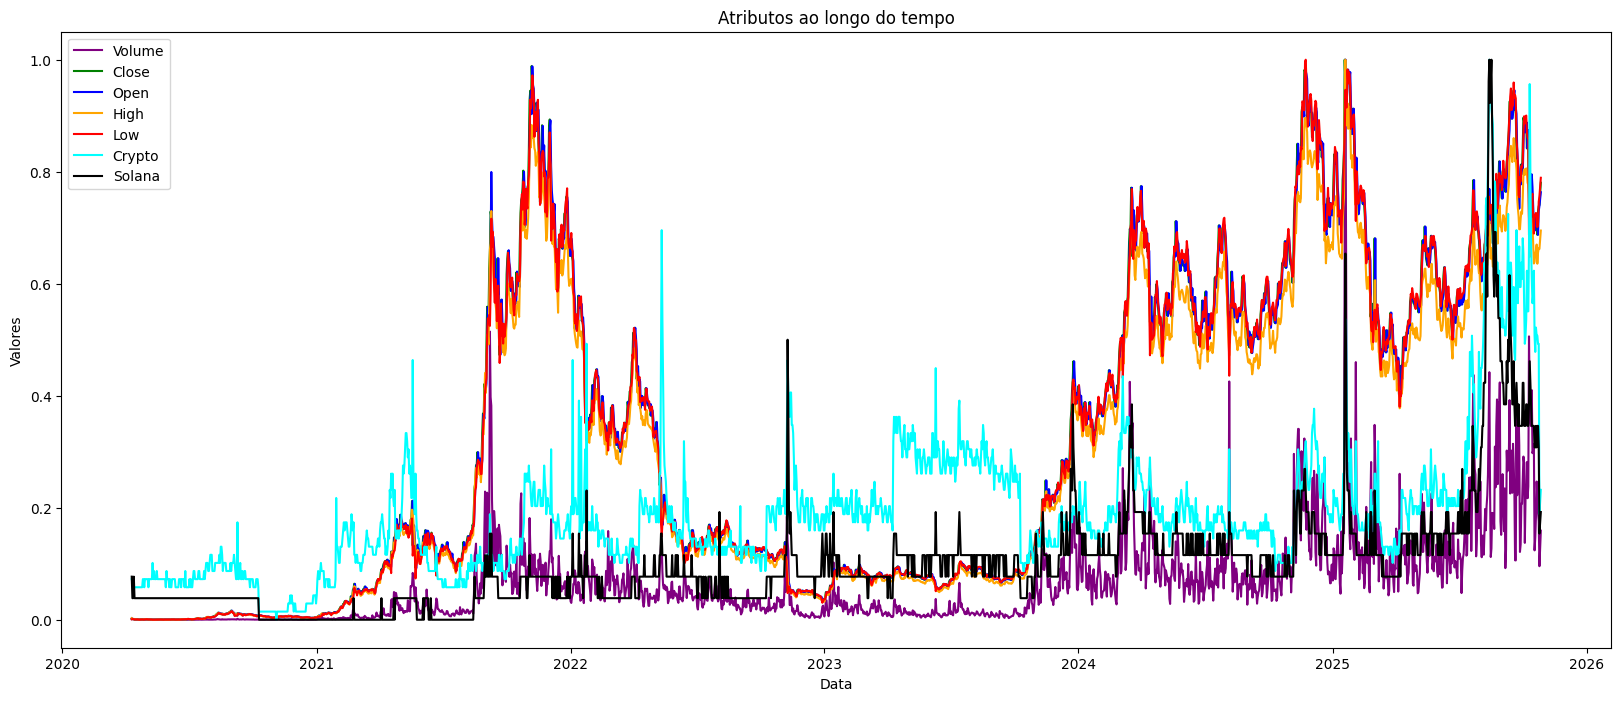

In [22]:
plt.figure(figsize=(20,8))

plt.plot(data_scaled.index, data_scaled['Volume'], label='Volume', color='purple')
plt.plot(data_scaled.index, data_scaled['Close'], label='Close', color='green')
plt.plot(data_scaled.index, data_scaled['Open'], label='Open', color='blue')
plt.plot(data_scaled.index, data_scaled['High'], label='High', color='orange')
plt.plot(data_scaled.index, data_scaled['Low'], label='Low', color='red')
plt.plot(data_scaled.index, data_scaled['crypto'], label='Crypto', color='cyan')
plt.plot(data_scaled.index, data_scaled['solana'], label='Solana', color='black')


plt.title('Atributos ao longo do tempo')
plt.xlabel('Data')
plt.ylabel('Valores')
plt.legend()
plt.show()

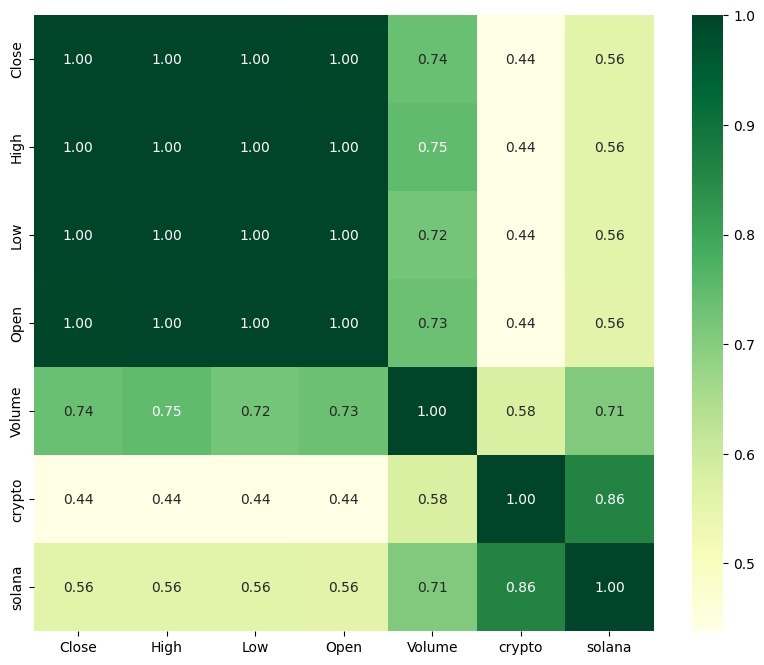

In [23]:
plt.figure(figsize=(10, 8)) 
sns.heatmap(data_merged.corr(), annot=True, cmap="YlGn", fmt=".2f")
plt.show()